In [65]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [66]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 26  # Life-raft, no ballast

14:29:38 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: C:/Users/bente/Documents/THESIS/Globcurrent/*.nc
14:29:38 INFO    opendrift.readers.reader_netCDF_CF_generic:104: Opening files with MFDataset
14:29:39 DEBUG   opendrift.readers.reader_netCDF_CF_generic:119: Finding coordinate variables.
14:29:39 DEBUG   opendrift.readers.reader_netCDF_CF_generic:134: Parsing CF grid mapping dictionary: {'grid_mapping_name': 'latitude_longitude', 'semi_major_axis': 6378137, 'inverse_flattening': 298.257223563}
14:29:39 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'y': 'latitude', 'x': 'longitude', 'z': 'depth'}
14:29:39 DEBUG   opendrift.readers.basereader.variables:608: Setting buffer size 6 for reader C:/Users/bente/Documents/THESIS/Globcurrent/*.nc, assuming a maximum average speed of 5 m/s and time span of 6:00:00
14:29:39 INFO    opendrift.readers.basereader:166: Variable x_sea_water_velocity will be rotated from eastw

In [67]:
duration = timedelta(hours=72)                # 3 days
start_time = datetime(2023,2,19,3,12,8)
end_time = start_time + duration

In [134]:
# Set the desired grid size
grid_size_lon = 0.2  # Change this to your desired grid size
grid_size_lat = 0.2

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(26.5, 28, grid_size_lon)
lat_bins = np.arange(-37.5, -36.3, grid_size_lat)

In [135]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [136]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 100) # Much coarser CCC
        lats[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 100)

# FWD

In [1]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd_1922feb_raft_capsize_xwind_v2.nc"

In [ ]:
ofwd = Leeway(loglevel=0)
ofwd.add_reader([reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')

ofwd.set_config('environment:constant:x_sea_water_velocity', 0)
ofwd.set_config('environment:constant:y_sea_water_velocity', 0)
ofwd.set_config('environment:constant:y_wind', 0)

ofwd.set_config('capsizing', True)
ofwd.set_config('capsizing:wind_threshold', 15)
ofwd.set_config('capsizing:wind_threshold_sigma', 5)
ofwd.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=600, time_step_output=3600, outfile=outfile)

14:44:27 DEBUG   opendrift.config:161: Adding 10 config items from environment
14:44:27 DEBUG   opendrift.config:161: Adding 5 config items from environment
14:44:27 DEBUG   opendrift.config:161: Adding 16 config items from __init__
14:44:27 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
14:44:27 DEBUG   opendrift.config:161: Adding 5 config items from __init__
14:44:27 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
14:44:27 DEBUG   opendrift.config:161: Adding 6 config items from leeway
14:44:27 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
14:44:27 DEBUG   opendrift.models.basemodel.environment:328: Added reader C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc
14:44:27 INFO    opendrift.models.leeway:309: Seeding elements of object type 26: LIFE-RAFT-NB-1 (Life-raft, no ballast (NB) system, general (mean values

In [139]:
fwd = xr.open_dataset(outfile)

In [140]:
len(fwd.trajectory)

4200

In [141]:
capsized = []
for i in range(len(fwd.trajectory)):
    capsized.append(fwd.isel(trajectory=i).capsized.values[-1])

In [142]:
np.count_nonzero(capsized)

4199

14:48:48 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
14:48:48 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


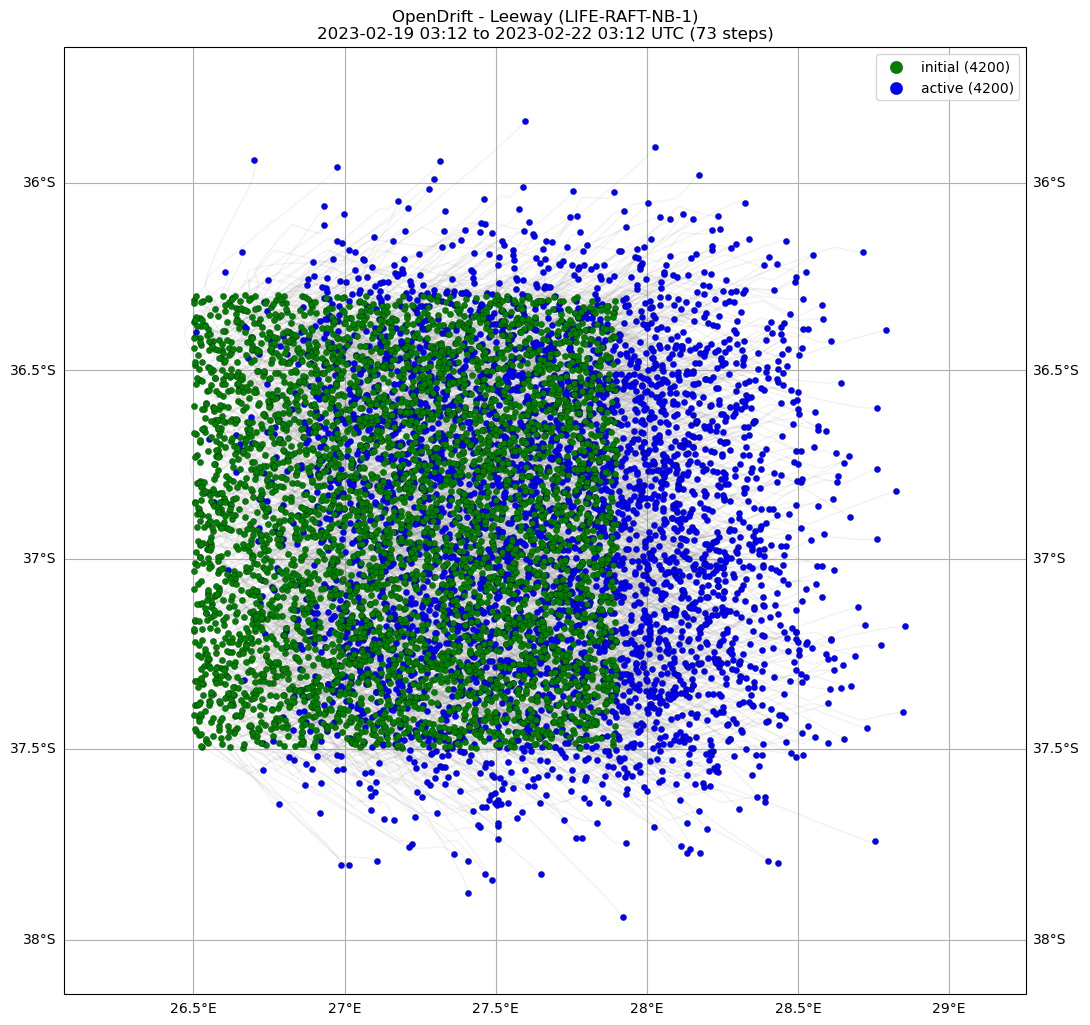

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-19 03:12 to 2023-02-22 03:12 UTC (73 steps)'}>,
 <Figure size 1100x1082.1 with 1 Axes>)

In [143]:
from matplotlib.colors import ListedColormap
ofwd.plot(color='capsized', cmap=ListedColormap(['black','red']), fast=True)

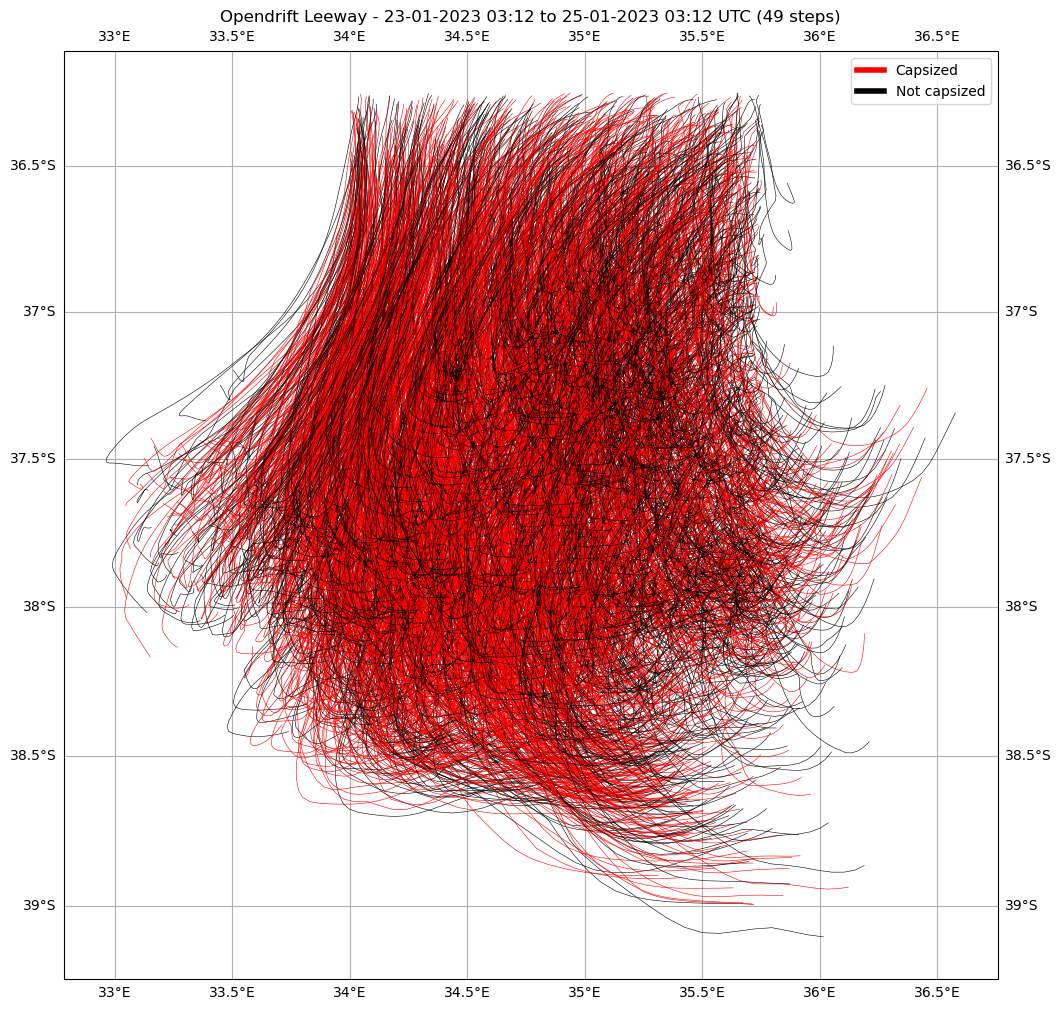

In [18]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    if capsized[i]>0: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    else: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
ccrs.Geodetic()

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Capsized', 'Not capsized'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [144]:
## FORWARD ## 
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

## BACKWARDS

In [83]:
# orev = Leeway(loglevel=50)

In [84]:
# outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2325jan_raft_capsize_v2.nc"

In [85]:
# lonend1 = np.array(lonend0)
# latend1 = np.array(latend0)

In [86]:
# lonend = lonend1[~np.isnan(lonend0)]
# latend = latend1[~np.isnan(latend0)]

In [87]:
# orev = Leeway(loglevel=50)
# orev.add_reader([reader_globcur, reader_wind])

# orev.set_config('drift:advection_scheme', 'runge-kutta4')
# orev.set_config('environment:fallback:x_sea_water_velocity', 0)
# orev.set_config('environment:fallback:y_sea_water_velocity', 0)

# orev.set_config('capsizing', True)
# orev.set_config('capsizing:wind_threshold', 20)
# orev.set_config('capsizing:wind_threshold_sigma', 5)
# orev.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

# #orev.set_config('drift:horizontal_diffusivity', 20)
# orev.seed_elements(lon=lonend, lat=latend, radius_type='uniform', time=end_time, object_type=object_type, capsized=1)
# orev.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd)

In [88]:
# bwd = xr.open_dataset(outfile_bwd)

In [89]:
# capsized_bwd = []
# for i in range(len(bwd.trajectory)):
#     capsized_bwd.append(bwd.isel(trajectory=i).capsized.values[-1])

In [90]:
# np.count_nonzero(capsized_bwd)

In [91]:
# len(bwd.trajectory)

In [92]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(bwd.trajectory)):
#     if capsized_bwd[i]>0: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
#     else: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
# ccrs.Geodetic()

# custom_lines = [#Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 Line2D([0], [0], color='black', lw=4)]

# ax.legend(custom_lines, ['Capsized', 'Not capsized'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 25-01-2023 03:12 to 23-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Comparison

In [93]:
### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

In [94]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='blue', marker='o')
#     fwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='lightblue', marker='o')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='red', marker='o')
#     bwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='pink', marker='o')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Picking one as 'truth'

In [174]:
n = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []

traj = np.arange(0,len(fwd.trajectory),1)

for i in range(1):
    a = np.random.choice(traj)
    a_traj.append(a)
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend0))
        dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<10000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(fwd.isel(trajectory=hits[m]).lon.values[-1][0])
            hit_start_lats.append(fwd.isel(trajectory=hits[m]).lat.values[-1][0])

In [175]:
fwd.isel(trajectory=a).capsized.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)

In [176]:
hits.values[0]

array([ 943, 1342, 1403, 1408, 1486, 1523, 1880, 1912, 1918, 2014, 2027,
       2035, 2051, 2055, 2059, 2079, 2096, 2106, 2117, 2119, 2121, 2129,
       2147, 2172, 2174, 2237, 2253, 2383, 2512, 2588, 2605, 2612, 2622,
       2650, 2653, 2663, 2668, 2670, 2677, 2678, 2688, 2699, 2705, 2715,
       2721, 2732, 2733, 2741, 2754, 2755, 2761, 2774, 2775, 2778, 2792,
       2797, 2799, 2802, 2835, 2851, 2857, 2871, 2873, 2889, 3103, 3108,
       3126, 3213, 3256, 3263, 3265, 3290, 3346, 3357, 3394], dtype=int64)

In [177]:
xfwd = fwd.isel(trajectory=hits.values[0])

In [178]:
capsized_xfwd = []
for i in range(len(xfwd.trajectory)):
    capsized_xfwd.append(xfwd.isel(trajectory=i).capsized.values[-1])

In [179]:
np.count_nonzero(capsized_xfwd)

75

In [180]:
len(xfwd.trajectory)

75

In [181]:
xlon = []       # lon for 'hits'
xlat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    xlon.append(xfwd.isel(trajectory=i).lon.values[0])
    xlat.append(xfwd.isel(trajectory=i).lat.values[0])

In [257]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(xlon, xlat, xlon_bins, xlat_bins)

In [183]:
o_hit = opendrift.open(outfile, elements=hits.values[0])

14:51:55 DEBUG   opendrift.config:161: Adding 10 config items from environment
14:51:55 DEBUG   opendrift.config:161: Adding 5 config items from environment
14:51:55 DEBUG   opendrift.config:161: Adding 16 config items from __init__
14:51:55 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
14:51:55 DEBUG   opendrift.config:161: Adding 5 config items from __init__
14:51:55 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
14:51:55 DEBUG   opendrift.config:161: Adding 6 config items from leeway
14:51:55 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
14:51:55 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd_1922feb_raft_capsize_xwind_v2.nc
14:51:56 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
14:51:56 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_win

14:51:56 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=False, lscale=None
14:51:56 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (26.340392684936525, 28.30589523315429, -37.52001113891602, -36.29662399291992)..
14:51:59 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (26.340392684936525, 28.30589523315429, -37.52001113891602, -36.29662399291992)..
14:52:01 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (26.340392684936525, 28.30589523315429, -37.52001113891602, -36.29662399291992)..


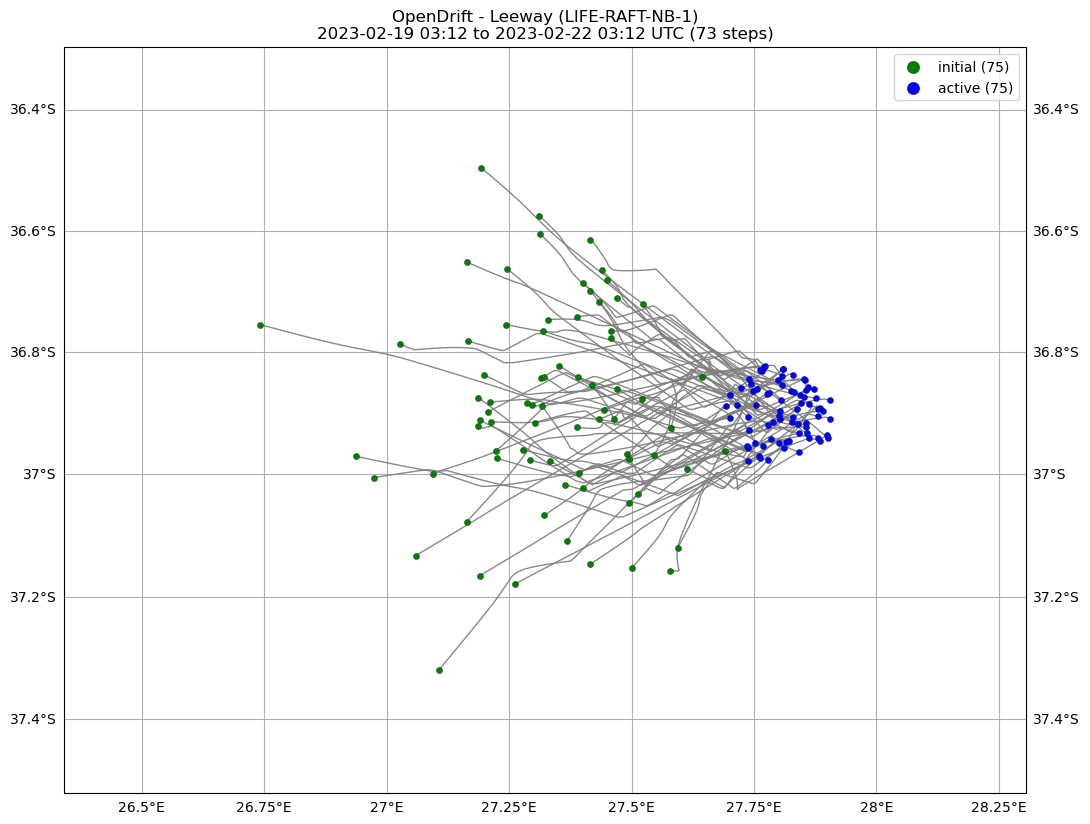

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-19 03:12 to 2023-02-22 03:12 UTC (73 steps)'}>,
 <Figure size 1100x856.272 with 1 Axes>)

In [184]:
o_hit.plot()

15:18:50 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:18:50 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


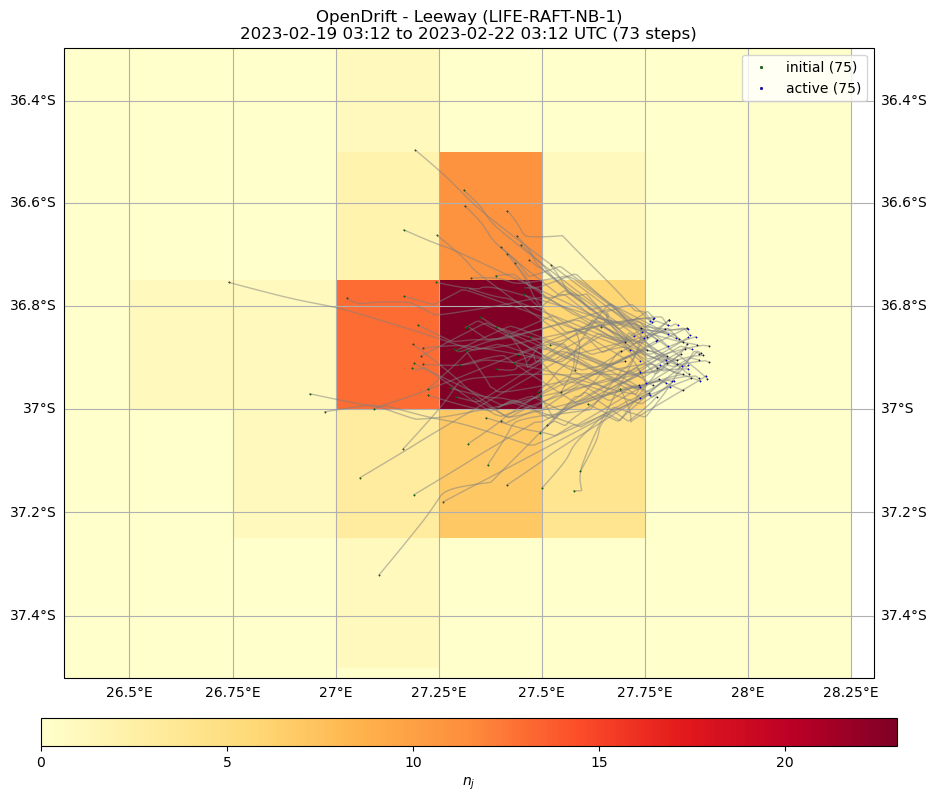

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-19 03:12 to 2023-02-22 03:12 UTC (73 steps)'}>,
 <Figure size 1100x856.272 with 2 Axes>)

In [249]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, cmap='YlOrRd')

In [186]:
outfile_bwd_truth = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_1922feb_raft_capsize_xwind_v3.nc"

In [187]:
orev1 = Leeway(loglevel=50)

14:52:26 DEBUG   opendrift.config:161: Adding 10 config items from environment
14:52:26 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [188]:
orev1 = Leeway(loglevel=50)
orev1.add_reader([reader_wind])

orev1.set_config('drift:advection_scheme', 'runge-kutta4')
orev1.set_config('environment:constant:x_sea_water_velocity', 0)
orev1.set_config('environment:constant:y_sea_water_velocity', 0)
orev1.set_config('environment:constant:y_wind', 0)

orev1.set_config('capsizing', True)
orev1.set_config('capsizing:wind_threshold', 15)
orev1.set_config('capsizing:wind_threshold_sigma', 5)
orev1.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev1.seed_elements(lon=ilon, lat=ilat, radius=10000, radius_type='uniform', number=len(hits.values[0]), time=end_time, object_type=object_type, capsized=1)
orev1.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd_truth)

In [189]:
bwd_truth = xr.open_dataset(outfile_bwd_truth)

In [190]:
capsized_bwd_truth = []
for i in range(len(bwd_truth.trajectory)):
    capsized_bwd_truth.append(bwd_truth.isel(trajectory=i).capsized.values[-1])

In [191]:
np.count_nonzero(capsized_bwd_truth)

0

In [192]:
len(bwd_truth.trajectory)

75

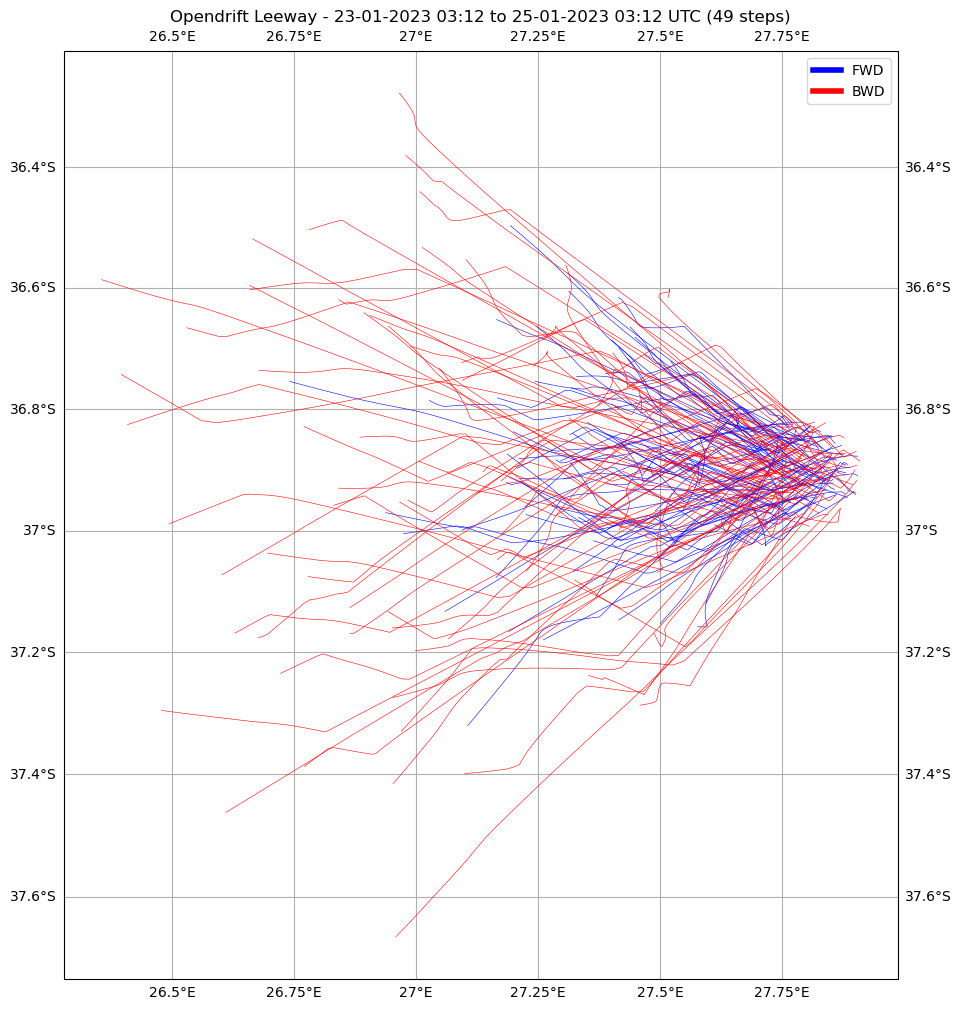

In [193]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [194]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(bwd_truth.trajectory)):
    lonback.append(bwd_truth.isel(trajectory=i).lon.values[-1])
    latback.append(bwd_truth.isel(trajectory=i).lat.values[-1])

In [255]:
### EXTENDED GRID ###

# Set the desired grid size
xgrid_size_lon = 0.25  # Change this to your desired grid size
xgrid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
xlon_bins = np.arange(26, 28.25, xgrid_size_lon)
xlat_bins = np.arange(-37.75, -36, xgrid_size_lat)

In [256]:
grid_counts_back = count_points_in_grid(lonback, latback, xlon_bins, xlat_bins)

In [197]:
o_back = opendrift.open(outfile_bwd_truth)

14:52:38 DEBUG   opendrift.config:161: Adding 16 config items from __init__
14:52:38 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
14:52:38 DEBUG   opendrift.config:161: Adding 5 config items from __init__
14:52:38 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
14:52:38 DEBUG   opendrift.config:161: Adding 6 config items from leeway
14:52:38 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
14:52:38 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd_1922feb_raft_capsize_xwind_v3.nc
14:52:38 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
14:52:38 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_wind -> None
14:52:38 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:fallback:x_wind -> None
14:52:38 DEBUG   opendrift.export.io_

15:19:07 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:19:07 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


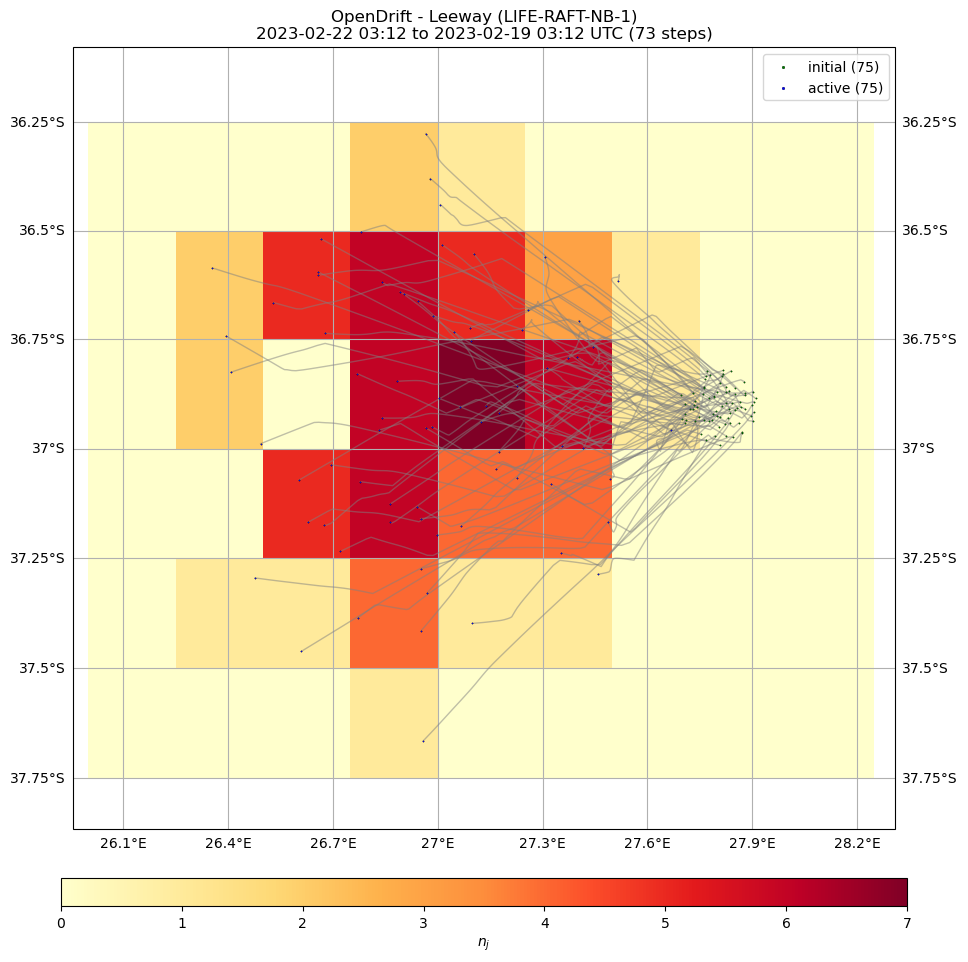

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-22 03:12 to 2023-02-19 03:12 UTC (73 steps)'}>,
 <Figure size 1100x1045.48 with 2 Axes>)

In [250]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, vmin=0, cmap='YlOrRd')

15:19:10 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:19:10 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


<Figure size 640x480 with 0 Axes>

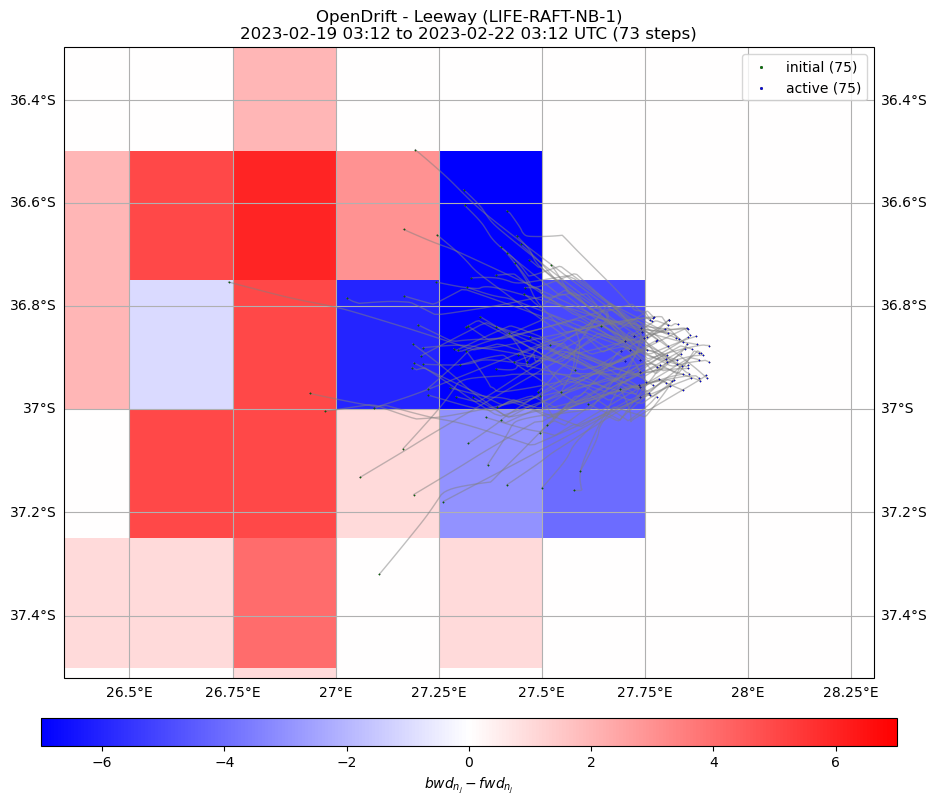

<Figure size 640x480 with 0 Axes>

In [251]:
plt.figure()

o_hit.plot(background=grid_counts_back-grid_counts, clabel='$bwd_{n_j} - fwd_{n_j}$', cmap='bwr', fast=True, markersize=1, lalpha=.5, vmin=-7, vmax=7)

plt.savefig('dif.png') 

In [259]:
dif = grid_counts_back-grid_counts

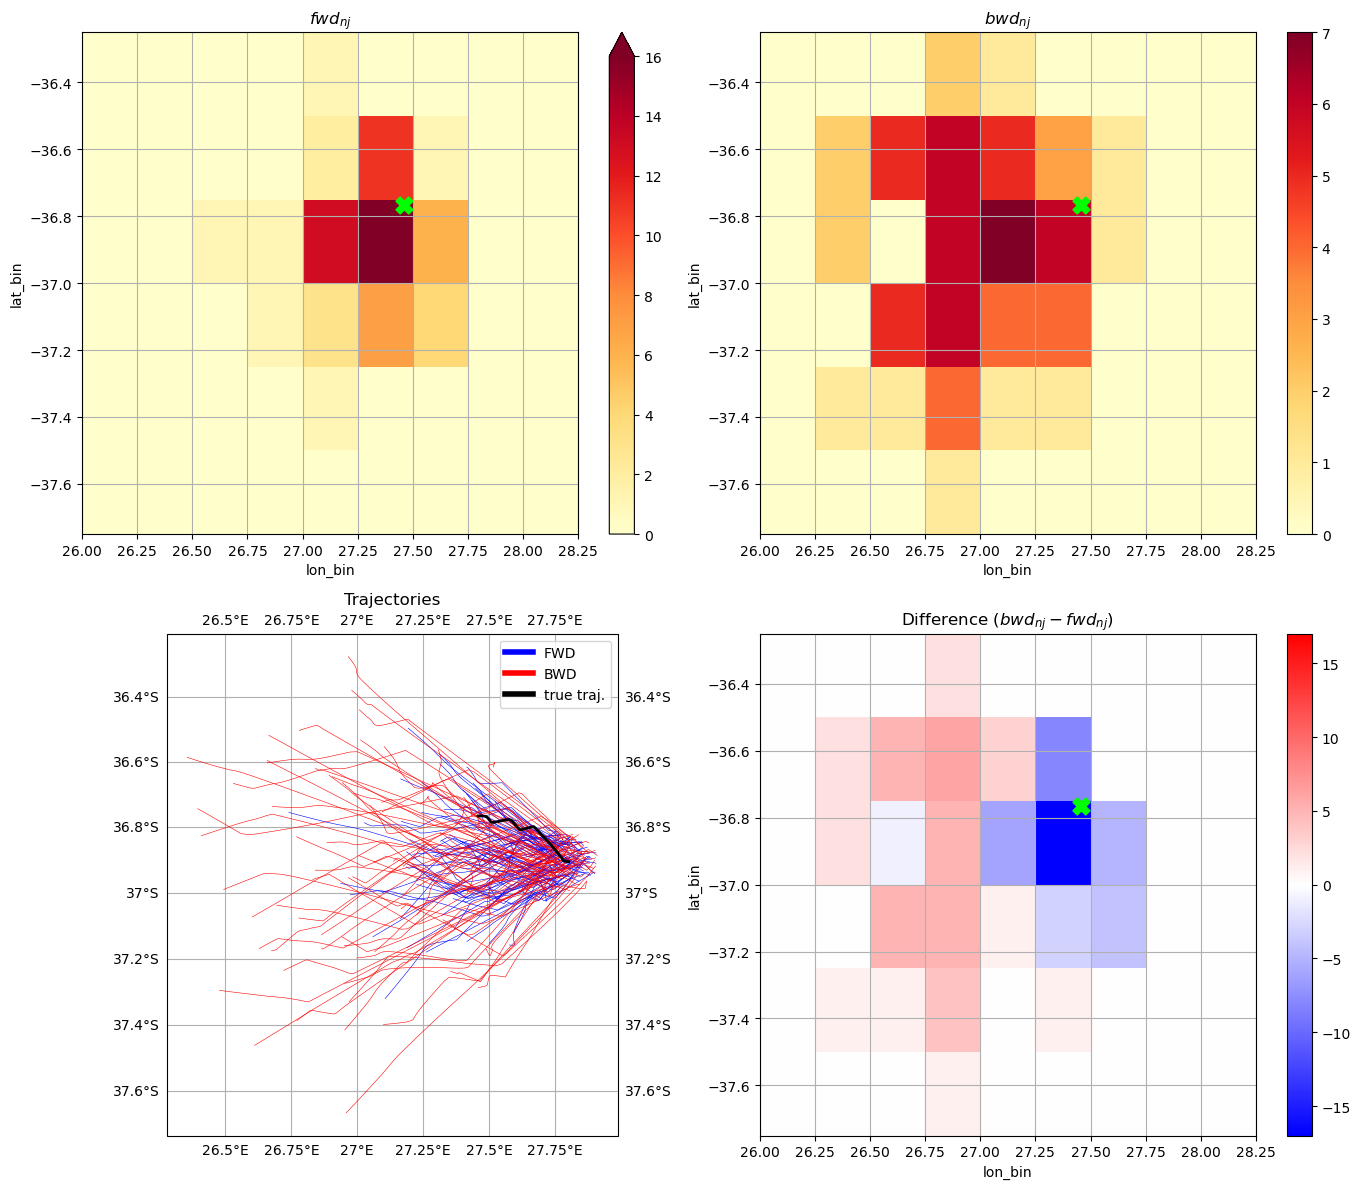

In [253]:
fig = plt.figure(figsize=(14,12))
size=150

plt.subplot(2,2,2)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(2,2,1)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], vmax=16, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(2,2,4)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(223, projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.'])

# plt.gca().autoscale()
plt.title('Trajectories')

plt.savefig('vierluik_2325jan.png') 
plt.show()

No time or obs dimension detected.
No time or obs dimension detected.


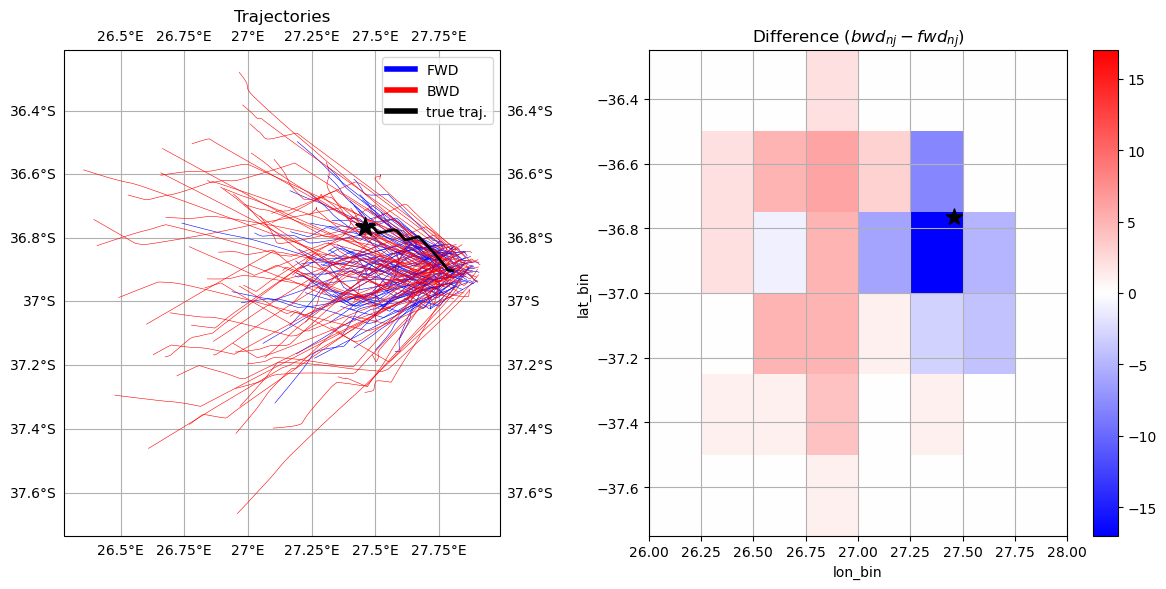

In [267]:
fig = plt.figure(figsize=(12,6))
size=150

plt.subplot(1,2,2)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='*', color='black')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(121, projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)
fwd.isel(trajectory=a).isel(time=0).traj.plot(marker='*', markersize=15, color='black')

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.'])
plt.title('Trajectories')

plt.savefig('dif_1922feb.pdf')

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

IndexError: index 120 is out of bounds for axis 0 with size 73

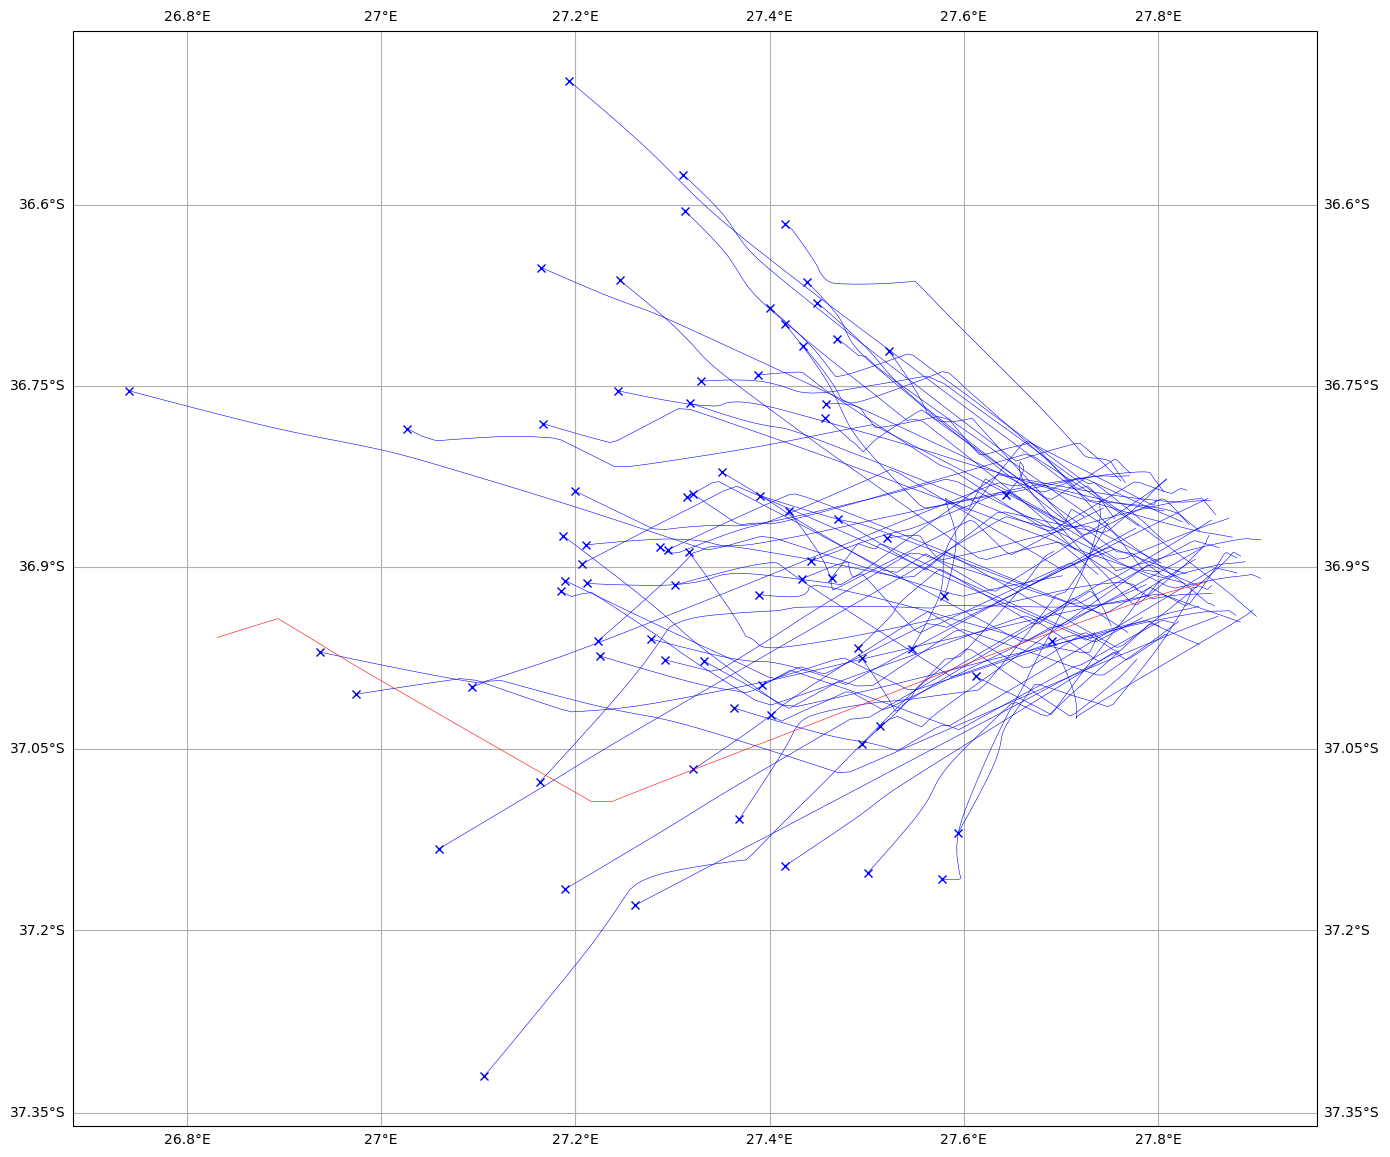

In [211]:
fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    if capsized_xfwd[i]<1:
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='o', color='blue')
    else: 
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='x', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    if capsized_bwd_truth[i]>0: 
        bwd_truth.isel(trajectory=i).isel(time=120).traj.plot(marker='x', color='red')
    else: 
        bwd_truth.isel(trajectory=i).isel(time=120).traj.plot(marker='o', color='red')
        
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
plt.title('Trajectories')
plt.show()

In [ ]:
wind = np.sqrt(np.square(fwd.isel(trajectory=a_traj).x_wind.values)+np.square(fwd.isel(trajectory=a_traj).y_wind.values))

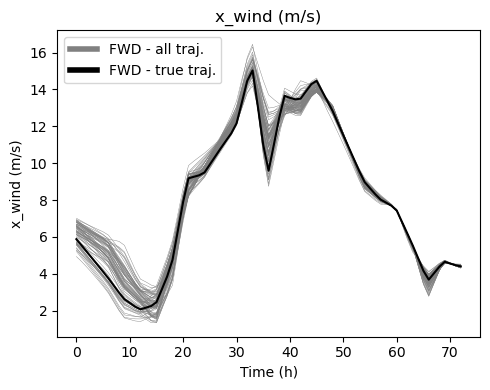

In [240]:
plt.figure(figsize=(5,4))

for i in range(len(xfwd.trajectory)):
    plt.plot(xfwd.isel(trajectory=i).x_wind, color='grey',linewidth=0.3)

plt.plot(wind[0], color='black')
plt.xlabel('Time (h)')
plt.ylabel('x_wind (m/s)')

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                #Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

plt.legend(custom_lines, ['FWD - all traj.', 'FWD - true traj.'])
plt.title('x_wind (m/s)')

plt.savefig('x_wind_1922feb.pdf')

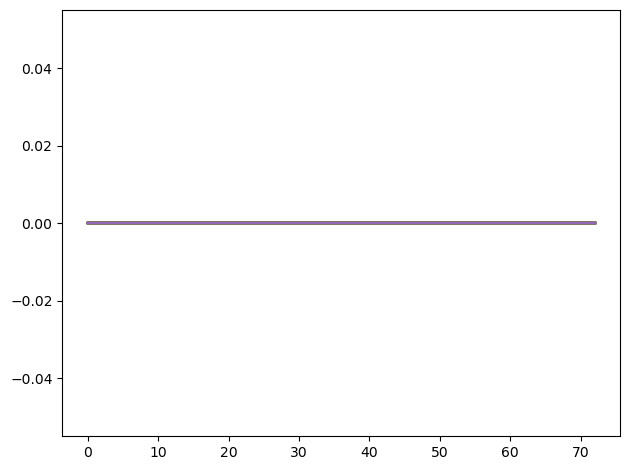

In [219]:
for i in range(len(bwd_truth.trajectory)):
    plt.plot(bwd_truth.isel(trajectory=i).y_wind)